# Grad-CAM

- Gradient-weighted Class Activation Mapping
- Technique for making Convolutional Neural Network (CNN) models more transparent by visualizing the regions of input that are important for predictions from these models
- It helps in understanding which parts of a given image lead the CNN to its final classification decision.


In [ ]:
! pip install pytorch-gradcam

In [ ]:
# Load libraries
import torch
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.nn as nn

import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

import gradcam
from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

In [ ]:
# Define the model architecture (must be the same as the saved model)
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# Load the model from the file
model.load_state_dict(torch.load('model_cifar10.pth'))
model.eval()  # Set the model to evaluation mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Define transformations for the input data
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to size used by ResNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# Get test dataset
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Files already downloaded and verified


In [ ]:
# Define the CIFAR-10 Classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
# Setup Grad-CAM
target_layer = model.layer4[-1]  # Target the last layer of ResNet18
gradcam = GradCAM(model, target_layer)
gradcam_pp = GradCAMpp(model, target_layer)

In [ ]:
# Function to select a random image from the test dataset and visualize Grad-CAM
def visualize_random_image_with_gradcam(test_loader, classes, model, gradcam, gradcam_pp):
    images, labels = next(iter(test_loader))
    image, true_label = images[0], labels[0]

    # Move the image to the correct device and prepare it for the model
    image = image.to(next(model.parameters()).device)
    model.eval()  # Set the model to evaluation mode

    # Perform the forward pass to get the logits
    with torch.no_grad():
        logits = model(image.unsqueeze(0))
        _, predicted = torch.max(logits, 1)
        predicted_label = predicted.item()

    # Generate the Grad-CAM mask
    mask, _ = gradcam(image.unsqueeze(0))
    heatmap, result = visualize_cam(mask, image)

    # Generate the Grad-CAM++ mask
    mask_pp, _ = gradcam_pp(image.unsqueeze(0))
    heatmap_pp, result_pp = visualize_cam(mask_pp, image)

    # Display results
    plt.figure(figsize=(10, 10))

    # Original Image with true label and predicted label
    plt.subplot(1, 4, 1)
    original_image = np.transpose(image.cpu().numpy(), (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    plt.imshow(original_image)
    plt.title(f'Label: {classes[true_label]} | Pred: {classes[predicted_label]}')

    # Grad-CAM Heatmap
    plt.subplot(1, 4, 2)
    heatmap = np.transpose(heatmap.squeeze().cpu().numpy(), (1, 2, 0))
    plt.imshow(original_image)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Apply the heatmap on top of the image
    plt.title(f'Grad-CAM')

    # Grad-CAM++ Heatmap
    plt.subplot(1, 4, 3)
    heatmap_pp = np.transpose(heatmap_pp.squeeze().cpu().numpy(), (1, 2, 0))
    plt.imshow(original_image)
    plt.imshow(heatmap_pp, cmap='jet', alpha=0.5)  # Apply the heatmap on top of the image
    plt.title(f'Grad-CAM++')

    # Overlay
    plt.subplot(1, 4, 4)
    combined_image = original_image + heatmap_pp
    combined_image = combined_image / np.max(combined_image)  # Normalize to [0,1] for display
    plt.imshow(combined_image)
    plt.title('Overlay')

    plt.show()

    # Print out the true label and the model's prediction
    print(f'Original label: {classes[true_label]}')
    print(f'Predicted label: {classes[predicted_label]}')

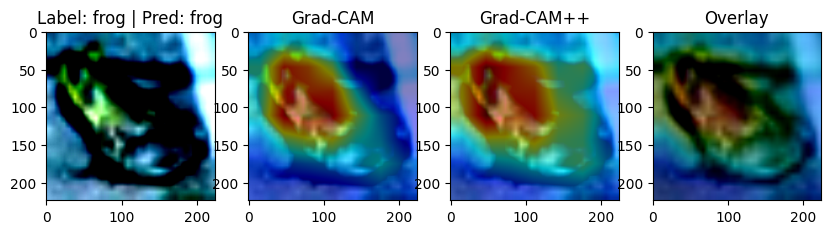

Original label: frog
Predicted label: frog


In [ ]:
visualize_random_image_with_gradcam(test_loader, classes, model, gradcam, gradcam_pp)

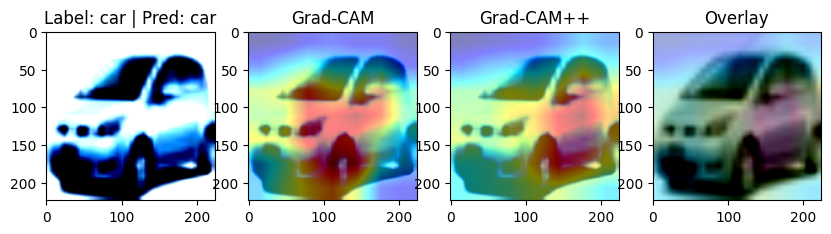

Original label: car
Predicted label: car


In [ ]:
visualize_random_image_with_gradcam(test_loader, classes, model, gradcam, gradcam_pp)

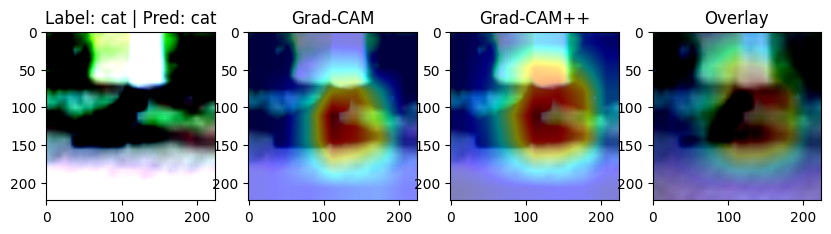

Original label: cat
Predicted label: cat


In [ ]:
visualize_random_image_with_gradcam(test_loader, classes, model, gradcam, gradcam_pp)

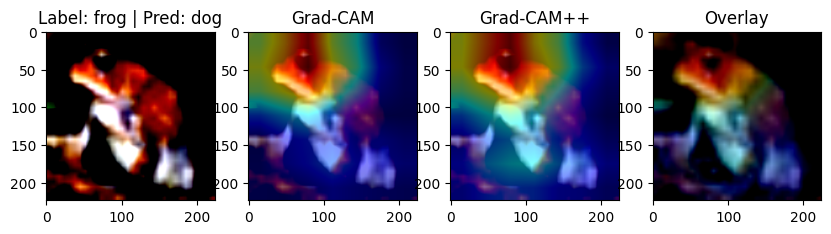

Original label: frog
Predicted label: dog


In [ ]:
visualize_random_image_with_gradcam(test_loader, classes, model, gradcam, gradcam_pp)

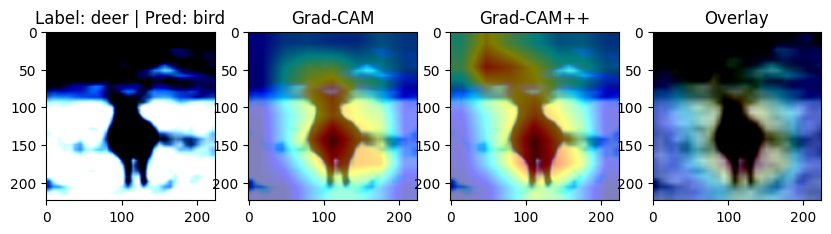

Original label: deer
Predicted label: bird


In [ ]:
visualize_random_image_with_gradcam(test_loader, classes, model, gradcam, gradcam_pp)

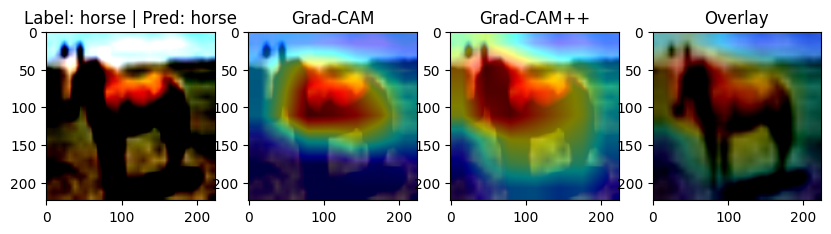

Original label: horse
Predicted label: horse


In [ ]:
visualize_random_image_with_gradcam(test_loader, classes, model, gradcam, gradcam_pp)

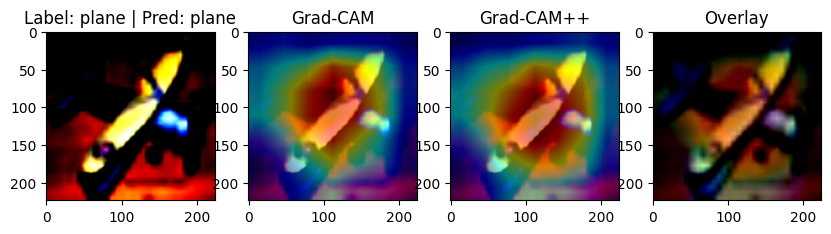

Original label: plane
Predicted label: plane


In [ ]:
visualize_random_image_with_gradcam(test_loader, classes, model, gradcam, gradcam_pp)

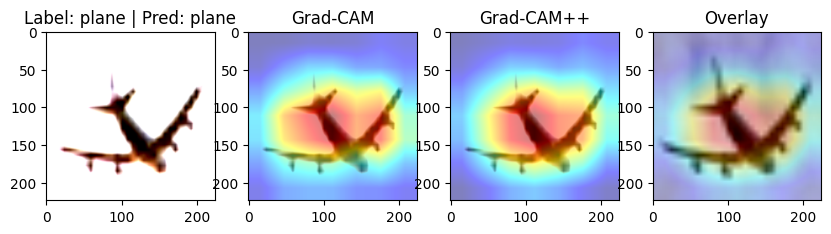

Original label: plane
Predicted label: plane


In [ ]:
visualize_random_image_with_gradcam(test_loader, classes, model, gradcam, gradcam_pp)

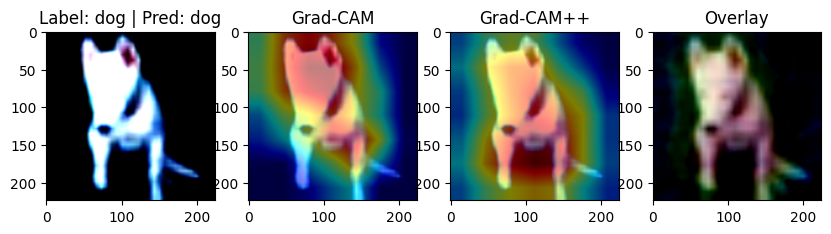

Original label: dog
Predicted label: dog


In [ ]:
visualize_random_image_with_gradcam(test_loader, classes, model, gradcam, gradcam_pp)